<a href="https://colab.research.google.com/github/slucey-cs-cmu-edu/RVSS24/blob/main/ConvMixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvMixer Study

This notebook showcases the interesting findings about Convolution in [George's paper](https://georgecazenavette.github.io/pdfs/channel_mixing.pdf) and our [impulse filter](https://arxiv.org/pdf/2401.12511.pdf). In this notebook, we use [Convmixer](https://arxiv.org/pdf/2201.09792.pdf) as the baseline convolution model.

The notebook is divided into following sections:
* [ConvMixer Baseline](#scrollTo=cDRlAKuYZqOg)
* [Mmodified Simple ViT Models](#scrollTo=-ImBjKzYuchD)
* [Impulse Initialization](#section_3)

## Section 0: Import Functions & Dataloader

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import  pyplot as plt

import os
import time
import argparse

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

parser = argparse.ArgumentParser()
args = parser.parse_args('')
print(args)

Namespace()


Preparing dataset

In [2]:
#@markdown Choose dataset from `CIFAR-10`, `CIFAR-100`, `SVHN`, or edit the code to add your own dataset.
args.dataset = "cifar10" # @param ["cifar10", "cifar100", "svhn"]
#@markdown Chooose whether use data augmentation or not. You can edit the code to add your own data augmentation.
args.data_aug = True #@param{type:'boolean'}
#@markdown Other parameters, you can change as you need.
args.data_path = "./data" # @param{type:'string'}
args.batch_size = 256 # @param{type:'integer'}
args.num_workers = 2 # @param{type:'integer'}
args.pin_memory = False #@param{type:'boolean'}

print(f'==> Preparing {args.dataset} data..')
# Get imagne size, dataset mean & std.
# Image size and patch size will also be used in future model claim.
if args.dataset[:5] == 'cifar':
    args.image_size = 32
    args.patch_size = 2
    dataset_mean = (0.4914, 0.4822, 0.4465)
    dataset_std = (0.2471, 0.2435, 0.2616)
elif args.dataset == 'svhn':
    args.image_size = 32
    args.patch_size = 2
    dataset_mean = (0.4376821, 0.4437697, 0.47280442)
    dataset_std = (0.19803012, 0.20101562, 0.19703614)
else:
    print('no available dataset')
# Set data augmentation for train set.
if args.data_aug:
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(args.image_size,scale=(1.0,1.0),ratio=(1.0,1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandAugment(2, 12),
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ])
test_transform = transforms.Compose([
    transforms.Resize(args.image_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std)
])
# Get train and test dataset.
# Need to specify number of classes for futrue model claim.
if args.dataset == 'cifar10':
    args.num_classes = 10
    train_dataset = torchvision.datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=test_transform)
elif args.dataset == 'cifar100':
    args.num_classes = 100
    train_dataset = torchvision.datasets.CIFAR100(root=args.data_path, train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR100(root=args.data_path, train=False, download=True, transform=test_transform)
elif args.dataset == 'svhn':
    args.num_classes = 10
    train_dataset = torchvision.datasets.SVHN(root=args.data_path, split='train', download=True, transform=train_transform)
    test_dataset = torchvision.datasets.SVHN(root=args.data_path, split='test', download=True, transform=test_transform)
else:
    print('no available dataset')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=args.pin_memory)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=args.pin_memory)

==> Preparing cifar10 data..


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Section 1: ConvMixer Baseline

---



ConvMixer is a Convolution based architecture inspired by [Vision Transformers (ViT)](https://arxiv.org/pdf/2010.11929.pdf) and [MLP-Mixer](https://arxiv.org/pdf/2105.01601.pdf). This secttion is based on the [official inplementation](https://github.com/locuslab/convmixer-cifar10/tree/main) of ConvMixer.

![ConvMixer and Simple ViT](https://drive.google.com/uc?export=view&id=1d5qKft2-t8LaZlyRjfqg4Jrsul5Or1U7)

### code
Since the architecture of ConvMixer is simple, the code is pretty short.

In [3]:
# from: https://github.com/locuslab/convmixer-cifar10/blob/main/train.py

import torch
from torch import nn

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

### Model & training settings

In [4]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 0.05 # @param
args.num_epochs = 25 # @param{type:'integer'}

model = ConvMixer(dim = 256, depth = 8, kernel_size=5, patch_size=2)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

lr_schedule = lambda t: np.interp([t], [0, args.num_epochs*2//5, args.num_epochs*4//5, args.num_epochs],
                                  [0, args.lr, args.lr/20.0, 0])[0]
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.005)
print(args)

scaler = torch.cuda.amp.GradScaler()
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_dataloader))
        optimizer.param_groups[0].update(lr=lr)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

cuda
using data parallel
Namespace(dataset='cifar10', data_aug=True, data_path='./data', batch_size=256, num_workers=2, pin_memory=False, image_size=32, patch_size=2, num_classes=10, lr=0.05, num_epochs=25)


<ipython-input-4-2c26cf7749da>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-4-2c26cf7749da>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-4-2c26cf7749da>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


epoch:  0, train_loss: 1.5800, train_acc: 0.4219, val_acc: 0.5759, lr: 5.000E-03, epoch_time: 48.6
epoch:  1, train_loss: 1.0506, train_acc: 0.6279, val_acc: 0.6618, lr: 1.000E-02, epoch_time: 44.2
epoch:  2, train_loss: 0.8642, train_acc: 0.6988, val_acc: 0.7490, lr: 1.500E-02, epoch_time: 45.2
epoch:  3, train_loss: 0.7769, train_acc: 0.7292, val_acc: 0.7612, lr: 2.000E-02, epoch_time: 45.2
epoch:  4, train_loss: 0.7122, train_acc: 0.7549, val_acc: 0.7579, lr: 2.500E-02, epoch_time: 44.1


KeyboardInterrupt: 

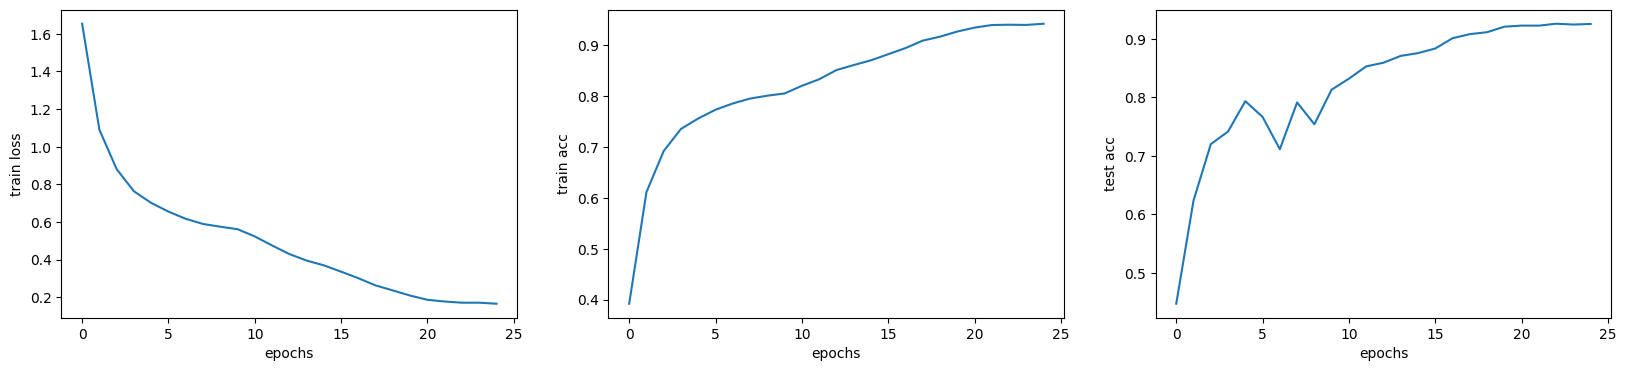

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

## Section 2: Modified Spatial Mixing Convolution


---


In George's [Rethinking the Role of Spatial Mixing](https://georgecazenavette.github.io/pdfs/channel_mixing.pdf), they point out a very interesting finding, that random spatial mixing convolution kernels can work well even they are not trained.

### code

Here we rewrite the code for spatial convolution with two more keyword augmentations: `init` (initialization) and `trainable` (if we want to train the weights)

In [ ]:
# from: https://github.com/osiriszjq/impulse_init/blob/main/convmixer.py

import torch
from torch import nn
import numpy as np

# initialization of convolusion kernel, C*1*K*K
def SpatialConv2d_init(C, kernel_size, init='random'):
    if (init == 'random')|(init == 'softmax'):
        weight = 1/kernel_size*(2*torch.rand((C,1,kernel_size,kernel_size))-1)
    elif init[:7] == 'lowrank':
        k = int(init[7:])
        Q = np.sqrt(1/kernel_size)*(2*torch.rand((C,k))-1)
        K = np.sqrt(1/kernel_size)*(2*torch.rand((k,kernel_size**2))-1)
        weight = torch.matmul(Q,K).reshape(C,1,kernel_size,kernel_size)
    elif init == 'impulse':
        k = torch.randint(0,kernel_size*kernel_size,(C,1))
        weight = torch.zeros((C,1,kernel_size*kernel_size))
        for i in range(C):
            for j in range(1):
                weight[i,j,k[i,j]] = 1
        weight = np.sqrt(1/3)*weight.reshape(C,1,kernel_size,kernel_size)
    elif init[:3] == 'box':
        weight = torch.zeros((C,1,kernel_size*kernel_size))
        for i in range(C):
            for j in range(1):
                k = np.random.choice(kernel_size*kernel_size,int(init[3:]),replace=False)
                weight[i,j,k] = 1
        weight = np.sqrt(1/int(init[3:])/3)*weight.reshape(C,1,kernel_size,kernel_size)
    elif init[:3] == 'gau':
        k = torch.randint(0,kernel_size,(C,1,2))
        weight = torch.zeros((C,1,kernel_size,kernel_size))
        for i in range(C):
            for j in range(1):
                for p in range(kernel_size):
                    for q in range(kernel_size):
                        weight[i,j,p,q] = (-0.5/float(init[3:])*((p-k[i,j,0])**2+(q-k[i,j,1])**2)).exp()
        weight = weight/((weight.flatten(1,3)**3).sum(1).mean()*kernel_size).sqrt()
    else:
        return -1
    return weight


# my spatial conv fuction, group=#channels, heads controls the number of different conv filters
class SpatialConv2d(nn.Module):
    def __init__(self, C, kernel_size, bias=True, init='random', heads = -1, trainable= True, input_weight=None):
        super(SpatialConv2d, self).__init__()
        self.C = C
        self.kernel_size = kernel_size
        self.init = init

        # different initialisation
        weight = SpatialConv2d_init(C,kernel_size,init=init)

        # how many heads or different filters we want to use
        if (heads<1)|(heads>C) :
            heads = C
        self.choice_idx = np.random.choice(heads,C,replace=(heads<C))

        # if use gloabal weight
        if input_weight is None:
            self.weight = nn.Parameter(weight[:heads],requires_grad=trainable)
        else:
            self.weight = input_weight

        if bias:
            bias = 1/kernel_size*(2*torch.rand((C))-1)
            self.bias = nn.Parameter(bias,requires_grad=trainable)
        else:
            self.bias = None


    def forward(self, x):
        if self.init == 'softmax':
            w_s = self.weight.shape
            return torch.nn.functional.conv2d(x, self.weight.flatten(2,3).softmax(-1).reshape(w_s)[self.choice_idx],self.bias,padding='same',groups=self.C)
        else:
            return torch.nn.functional.conv2d(x, self.weight[self.choice_idx], self.bias,padding='same',groups=self.C)


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10, init='random', trainable=True):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    # nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    SpatialConv2d(dim, kernel_size, init=init, trainable=trainable),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )


### Original settings

First we want to show that if we set `init=random` and `trainable=True`, the model is identical to the original one.





In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 0.05 # @param
args.num_epochs = 25 # @param{type:'integer'}
args.init = 'random' # @param{type:'string'}
args.trainable = True # @param{type:'boolean'}

model = ConvMixer(dim = 256, depth = 8, kernel_size=5, patch_size=2,
                  init=args.init, trainable=args.trainable)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

lr_schedule = lambda t: np.interp([t], [0, args.num_epochs*2//5, args.num_epochs*4//5, args.num_epochs],
                                  [0, args.lr, args.lr/20.0, 0])[0]
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.005)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler()
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_dataloader))
        optimizer.param_groups[0].update(lr=lr)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

cuda
using data parallel
Namespace(dataset='cifar10', data_aug=True, data_path='./data', batch_size=512, num_workers=2, pin_memory=False, image_size=32, patch_size=2, num_classes=10, lr=0.05, num_epochs=25, init='random', trainable=True)
epoch:  0, train_loss: 1.6400, train_acc: 0.4007, val_acc: 0.5141, lr: 5.000E-03, epoch_time: 48.6
epoch:  1, train_loss: 1.0910, train_acc: 0.6153, val_acc: 0.6662, lr: 1.000E-02, epoch_time: 48.5
epoch:  2, train_loss: 0.8797, train_acc: 0.6940, val_acc: 0.7441, lr: 1.500E-02, epoch_time: 47.8
epoch:  3, train_loss: 0.7581, train_acc: 0.7355, val_acc: 0.7222, lr: 2.000E-02, epoch_time: 46.8
epoch:  4, train_loss: 0.6998, train_acc: 0.7565, val_acc: 0.7538, lr: 2.500E-02, epoch_time: 53.3
epoch:  5, train_loss: 0.6506, train_acc: 0.7759, val_acc: 0.7828, lr: 3.000E-02, epoch_time: 50.8
epoch:  6, train_loss: 0.6233, train_acc: 0.7837, val_acc: 0.7447, lr: 3.500E-02, epoch_time: 51.6
epoch:  7, train_loss: 0.5891, train_acc: 0.7970, val_acc: 0.8095, lr

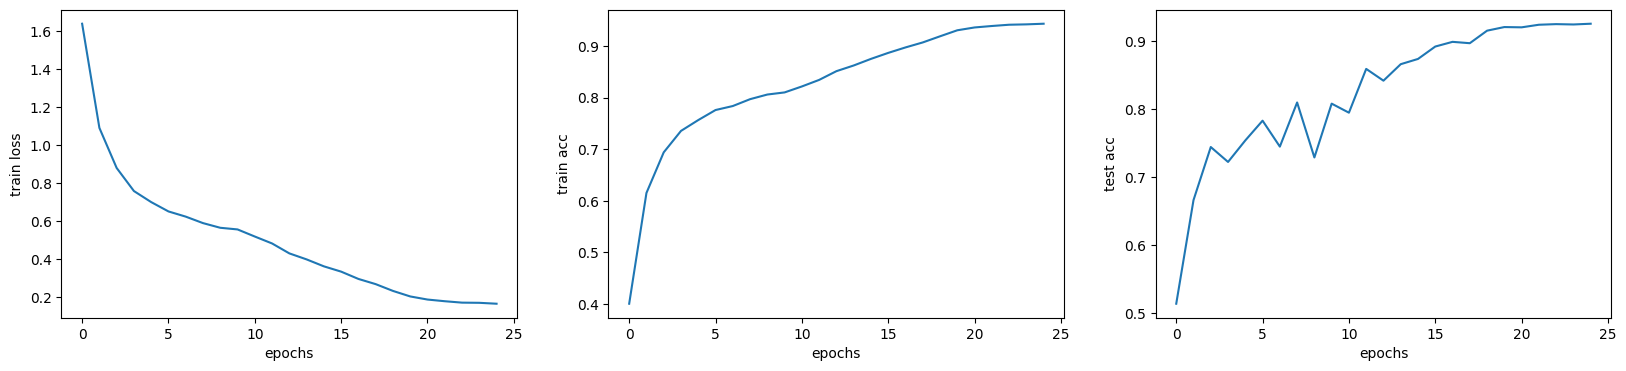

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### Random spatial mixing convolution kernels without training

Then if you set `trainable=False`, the weights in spatial convolution kernels are not trained, but the model still works well.

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 0.05 # @param
args.num_epochs = 25 # @param{type:'integer'}
args.init = 'random' # @param{type:'string'}
args.trainable = False # @param{type:'boolean'}

model = ConvMixer(dim = 256, depth = 8, kernel_size=5, patch_size=2,
                  init=args.init, trainable=args.trainable)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

lr_schedule = lambda t: np.interp([t], [0, args.num_epochs*2//5, args.num_epochs*4//5, args.num_epochs],
                                  [0, args.lr, args.lr/20.0, 0])[0]
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.005)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler()
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_dataloader))
        optimizer.param_groups[0].update(lr=lr)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

cuda
using data parallel
Namespace(dataset='cifar10', data_aug=True, data_path='./data', batch_size=512, num_workers=2, pin_memory=False, image_size=32, patch_size=2, num_classes=10, lr=0.05, num_epochs=25, init='random', trainable=False)
epoch:  0, train_loss: 1.6745, train_acc: 0.3851, val_acc: 0.5722, lr: 5.000E-03, epoch_time: 59.1
epoch:  1, train_loss: 1.1813, train_acc: 0.5809, val_acc: 0.6123, lr: 1.000E-02, epoch_time: 56.8
epoch:  2, train_loss: 0.9569, train_acc: 0.6622, val_acc: 0.7218, lr: 1.500E-02, epoch_time: 58.4
epoch:  3, train_loss: 0.8353, train_acc: 0.7076, val_acc: 0.7146, lr: 2.000E-02, epoch_time: 62.6
epoch:  4, train_loss: 0.7613, train_acc: 0.7355, val_acc: 0.7438, lr: 2.500E-02, epoch_time: 57.3
epoch:  5, train_loss: 0.7203, train_acc: 0.7487, val_acc: 0.7753, lr: 3.000E-02, epoch_time: 56.7
epoch:  6, train_loss: 0.6774, train_acc: 0.7664, val_acc: 0.7666, lr: 3.500E-02, epoch_time: 56.3
epoch:  7, train_loss: 0.6513, train_acc: 0.7762, val_acc: 0.7729, l

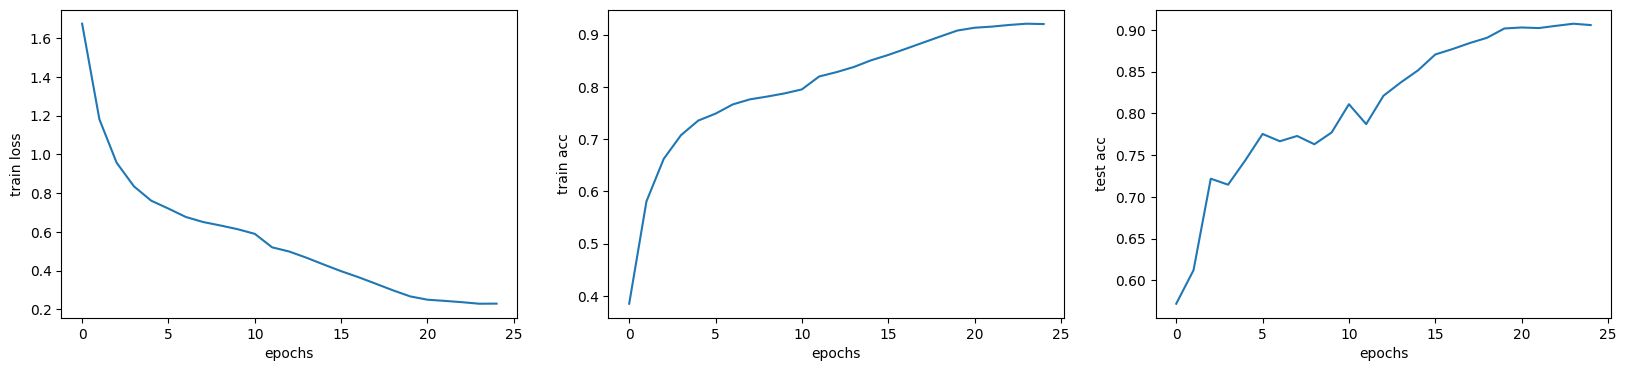

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

## Sction3: More possible initializations

---

In [our work](), we give an expanation to why random spatial mixing convolution kernel work, and have two examples to showcase our theory. *Impulse filter* which has a full rank should work as well, while a *box filter* with all ones should work poorly.

### Impulse filter

if you set `init=impulse` and `trainable=False`, the model still works well.

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 0.05 # @param
args.num_epochs = 25 # @param{type:'integer'}
args.init = 'impulse' # @param{type:'string'}
args.trainable = False # @param{type:'boolean'}

model = ConvMixer(dim = 256, depth = 8, kernel_size=5, patch_size=2,
                  init=args.init, trainable=args.trainable)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model).to(device) # make parallel
    cudnn.benchmark = True

lr_schedule = lambda t: np.interp([t], [0, args.num_epochs*2//5, args.num_epochs*4//5, args.num_epochs],
                                  [0, args.lr, args.lr/20.0, 0])[0]
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.005)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler()
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.to(device), y.to(device)

        lr = lr_schedule(epoch + (i + 1)/len(train_dataloader))
        optimizer.param_groups[0].update(lr=lr)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

Namespace(dataset='svhn', data_aug=True, data_path='./data', batch_size=256, num_workers=2, pin_memory=False, image_size=32, patch_size=2, num_classes=10, lr=0.05, num_epochs=25, init='impulse', trainable=False)


/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

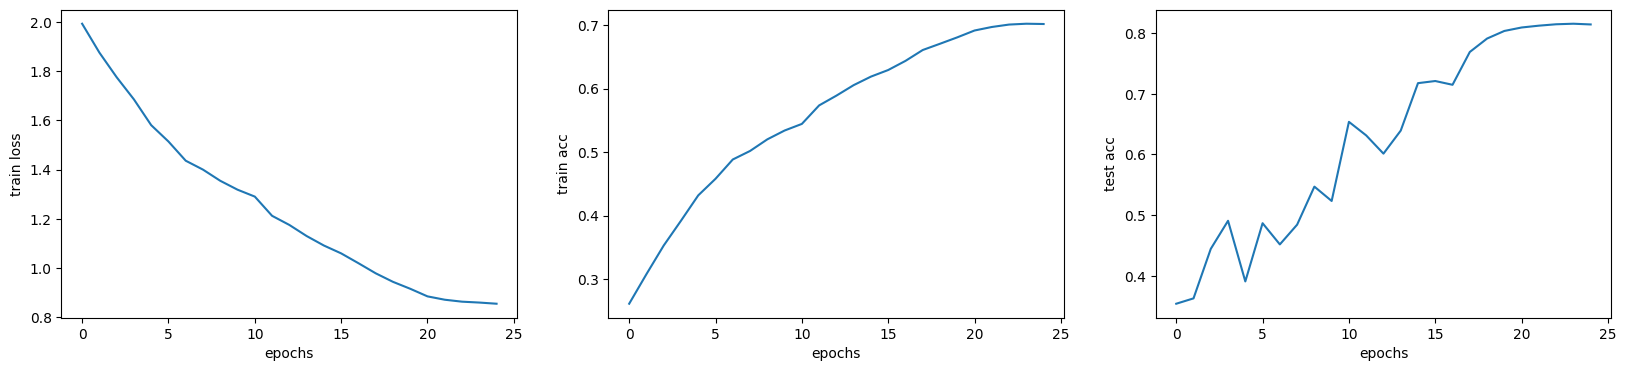

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### Box filter

if you set `init=box25` (25 here means the kernel have 25 ones in random positions and all other places are 0. For a $5\times 5$ kernel, this means the kernel is full of ones) and `trainable=False`, the model still works much worse.

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 0.05 # @param
args.num_epochs = 25 # @param{type:'integer'}
args.init = 'box25' # @param{type:'string'}
args.trainable = False # @param{type:'boolean'}

model = ConvMixer(dim = 256, depth = 8, kernel_size=5, patch_size=2,
                  init=args.init, trainable=args.trainable)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

lr_schedule = lambda t: np.interp([t], [0, args.num_epochs*2//5, args.num_epochs*4//5, args.num_epochs],
                                  [0, args.lr, args.lr/20.0, 0])[0]
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.005)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler()
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_dataloader))
        optimizer.param_groups[0].update(lr=lr)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

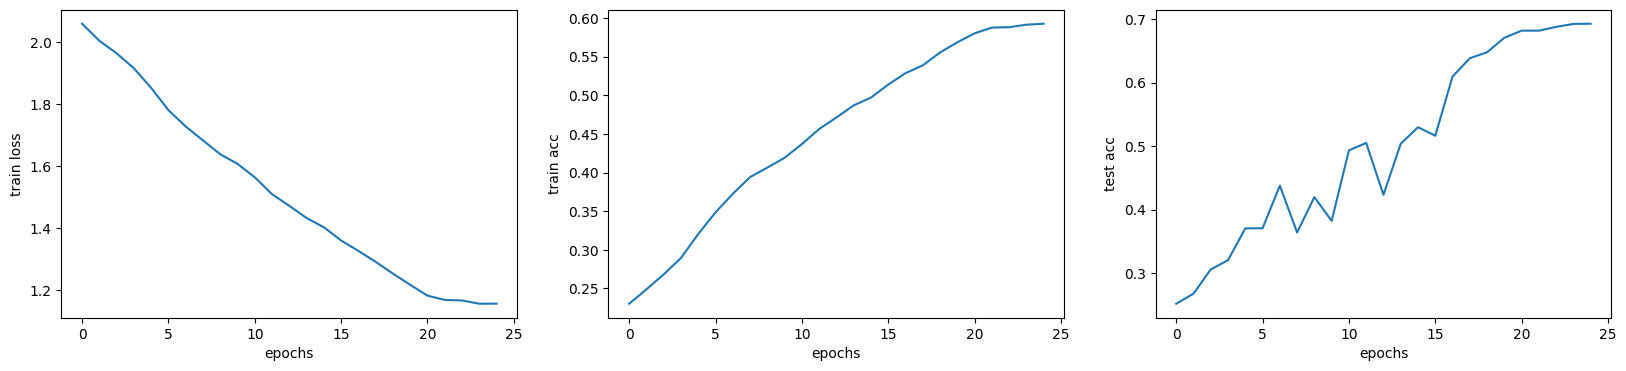

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### More box filters

You can try to change `init=box25` to `init=box1` and see as number of ones in the filter decreases, the rank of filter increases and the performance is also better.

In [ ]:
args.lr = 0.05
args.num_epochs = 25
args.trainable = False

# box filters to try
iis = [1,2,4,8,16,25]
train_losses_all = []
train_acces_all = []
test_acces_all = []
for ii in iis:
    args.init = 'box'+str(ii)
    model = ConvMixer(dim = 256, depth = 8, kernel_size=5, patch_size=2,
                      init=args.init, trainable=args.trainable)

    if 'cuda' in device:
        print(device)
        print("using data parallel")
        net = torch.nn.DataParallel(model) # make parallel
        cudnn.benchmark = True

    lr_schedule = lambda t: np.interp([t], [0, args.num_epochs*2//5, args.num_epochs*4//5, args.num_epochs],
                                      [0, args.lr, args.lr/20.0, 0])[0]
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.005)
    print(args)

    use_amp = True
    scaler = torch.cuda.amp.GradScaler()
    train_losses = []
    train_acces = []
    test_acces = []
    for epoch in range(args.num_epochs):
        start = time.time()
        train_loss, train_acc, n = 0, 0, 0
        for i, (X, y) in enumerate(train_dataloader):
            model.train()
            X, y = X.cuda(), y.cuda()

            lr = lr_schedule(epoch + (i + 1)/len(train_dataloader))
            optimizer.param_groups[0].update(lr=lr)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                output = model(X)
                loss = criterion(output, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            train_loss += loss.item() * y.size(0)
            train_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
        train_acc = train_acc/n
        train_loss = train_loss/n
        train_losses.append(train_loss)
        train_acces.append(train_acc)

        model.eval()
        test_acc, m = 0, 0
        with torch.no_grad():
            for i, (X, y) in enumerate(test_dataloader):
                X, y = X.cuda(), y.cuda()
                with torch.cuda.amp.autocast():
                    output = model(X)
                test_acc += (output.max(1)[1] == y).sum().item()
                m += y.size(0)
        test_acc = test_acc/m
        test_acces.append(test_acc)
        print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')
    train_losses_all.append(train_losses)
    train_acces_all.append(train_acces)
    test_acces_all.append(test_acces)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
np.save('/content/drive/')

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()